In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from functools import partial
import sys
from pathlib import Path

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.BayesIMPfull import *
from src.causalKLGPfull import *
from src.kernels import *
from src.GP_utils import *
from src.kernel_utils import *
from src.dgps import *
from src.CBO import *

In [2]:
# Getting observational and interventional data 
n = 100
n_int = 2
int_samples = 10**4
noise = 1.0
seed = 1
front_door = False
int_scale = 1

if front_door:
    method = "ATT_frontdoor_doB_b"
else:
    method = "CATE_backdoor_doD_bfixed"
A,B,C,D,E,Y,vals,EY = Simulation(n,n_int, 
           mc_samples_EYdoX = int_samples, 
           seed = seed, 
           draw_EYdoX = True, 
           noise = noise,
           method = method, 
           int_min=-int_scale*noise, 
           int_max = int_scale*noise,
           discrete_D = True
            )

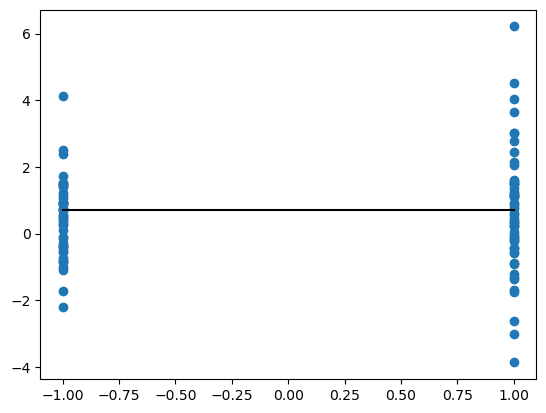

In [3]:
plt.plot(vals,EY, color = "black")
if front_door:
    plt.scatter(B,Y)
else:
    plt.scatter(D,Y)

In [4]:
# Settings
method = "bayesIMP" 
retrain_hypers = False
sample_split = True,
marginal_loss = False
cal_nulist = 2**torch.linspace(-4,4,5)
niter = 1000
learn_rate = 0.1

In [9]:
# Overwriting data definitions for convenience
A = B
V = C
if front_door:
    W = B
else:
    W = D.float()

model = BayesIMP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_W = GaussianKernel,
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   dim_W = W.size()[1],
                   samples = 10**5,
                   scale_V_init = Y.var()**0.5/2,
                   noise_Y_init = torch.log(Y.var()/4)
                  )
    
model.train(Y, A, V, W, niter, learn_rate)

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/BayesIMPfull.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_W.dist.scale = torch.tensor(measure_init*W.var()**0.5).requires_grad_(optimise_measure)


iter 0 P(Y|V) loss:  tensor(183.9303)
iter 100 P(Y|V) loss:  tensor(96.7377)
iter 200 P(Y|V) loss:  tensor(96.6448)
iter 300 P(Y|V) loss:  tensor(96.5080)
iter 400 P(Y|V) loss:  tensor(96.2796)
iter 500 P(Y|V) loss:  tensor(96.0859)
iter 600 P(Y|V) loss:  tensor(95.9580)
iter 700 P(Y|V) loss:  tensor(95.8705)
iter 800 P(Y|V) loss:  tensor(95.8066)
iter 900 P(Y|V) loss:  tensor(95.7577)
iter 0 P(V|A) loss:  tensor(-52923.2617)
iter 100 P(V|A) loss:  tensor(-72313.5000)
iter 200 P(V|A) loss:  tensor(-72322.5156)
iter 300 P(V|A) loss:  tensor(-72324.3750)
iter 400 P(V|A) loss:  tensor(-72318.9141)
iter 500 P(V|A) loss:  tensor(-72322.5625)
iter 600 P(V|A) loss:  tensor(-72317.5156)
iter 700 P(V|A) loss:  tensor(-72323.4766)
iter 800 P(V|A) loss:  tensor(-72316.2344)
iter 900 P(V|A) loss:  tensor(-72323.1562)


In [97]:
if front_door:
    doW = torch.zeros((1,1))
    doA = torch.linspace(-int_scale*noise,int_scale*noise,n_int)[:,None]
else:
    doA = torch.zeros((1,1))
    doW = torch.linspace(-int_scale*noise,int_scale*noise,n_int)[:,None]
mu = model.post_mean(Y,A,V,doA, W = W, doW = doW)
var = model.post_var(Y,A,V,doA, W = W, doW = doW, diag = True)

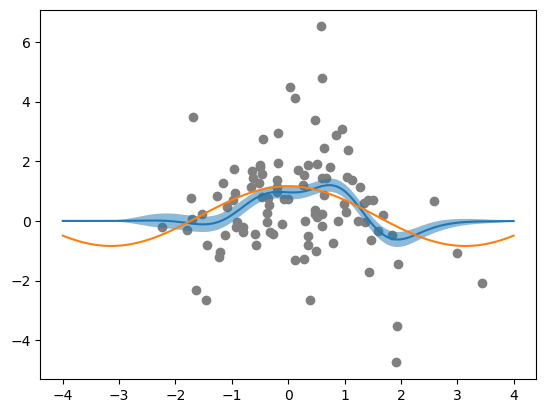

In [99]:
z  = 0.68
if front_door:
    plt.scatter(A,Y, color = "grey")
else:
    plt.scatter(W,Y, color = "grey")
plt.plot(vals,mu)
plt.plot(vals,EY)
plt.fill_between(vals.view(-1),(mu - z*var**0.5).view(-1), (mu + z*var**0.5).view(-1), 
                 alpha = 0.5)

In [15]:
# Doing Bayesian Optimisation
""" Get posterior funcs and CBO prior kernel """

if front_door:
    def mean(X):
        doA = X.reshape(len(X),1)
        doW = torch.zeros((1,1))      
        return model.post_mean(Y,A,V,doA, W=W, doW = doW)

    def cov(X, Z, diag = False):
    
        doA = X.reshape(len(X),1)
        doA2 = Z.reshape(len(Z),1)
        doW = torch.zeros((1,1))
        doW2 = torch.zeros((1,1))
    
        return model.post_var(Y,A,V,doA, doA2 = doA2,
                              W = W, doW = doW, doW2 = doW2,
                              diag = diag)
else:
    def mean(X):
        doA = torch.zeros((1,1))
        doW = X.reshape(len(X),1)
        return model.post_mean(Y,A,V,doA, W=W, doW = doW,reg = 1e-2) 

    
    def cov(X, Z, diag = False):
    
        doA = torch.zeros((1,1))
        doA2 = torch.zeros((1,1))
        doW = X.reshape(len(X),1)
        doW2 = Z.reshape(len(Z),1)
    
        return model.post_var(Y,A,V,doA, doA2 = doA2,
                              W = W, doW = doW, doW2 = doW2,
                              diag = diag, reg = 1e-2)

cbo_kernel = CBOPriorKernel(cov)

In [10]:
""" Run CBO """
n_iter = 20
noise_init = -10.0
cbo_reg = 1e-1
xi = 0.0
update_hyperparameters = False


# Define a grid of intervention points and precompute E[Y|do(x)]
doX = vals
EYdoX = EY.reshape(n_int,1)

# Random search for first intervention point
torch.manual_seed(seed)
start = torch.randint(0,99,(1,))[0]
doXtrain, EYdoXtrain = doX[start].reshape(1,1), EYdoX[start].reshape(1,1)

# Run CBO iters
doXeval, EYdoXeval = causal_bayesian_optimization(X_train = doXtrain, 
                                                    y_train = EYdoXtrain, 
                                                    kernel = cbo_kernel, 
                                                    mean = mean,
                                                    X_test = doX, 
                                                    Y_test = EYdoX, 
                                                    n_iter = n_iter, 
                                                    update_hyperparameters = update_hyperparameters,
                                                    xi = xi, 
                                                    print_ = True, 
                                                    minimise = False,
                                                    noise_init = noise_init,
                                                    reg = cbo_reg)

Iteration 1: X = tensor([0.7475]), Y = 0.894503116607666
Iteration 2: X = tensor([0.7071]), Y = 0.921363353729248
Iteration 3: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 4: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 5: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 6: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 7: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 8: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 9: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 10: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 11: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 12: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 13: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 14: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 15: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 16: X = tensor([-0.1414]), Y = 1.1511130332946777
Iteration 17: X = tensor([-0.1414]), Y = 1.1511130332

In [16]:
# Define a grid of intervention points and precompute E[Y|do(x)]
doX = vals
EYdoX = EY.reshape(n_int,1)

# Random search for first intervention point
start = torch.randint(0,99,(1,))[0]
doXtrain, EYdoXtrain = doX[start].reshape(1,1), EYdoX[start].reshape(1,1)

X_train = doXtrain
y_train = EYdoXtrain
kernel = cbo_kernel
mean = mean
X_test = doX
Y_test = EYdoX
update_hyperparameters = False
xi = 0.0
print_ = True
minimise = False
noise_init = -10.0
reg = 1e-3
n_iter = 1

if X_train is None or y_train is None:
    X_train = torch.empty((0, X_test.shape[1]))  # Initialize empty tensor
    y_train = torch.empty((0, 1))  # Initialize empty tensor

# Initialize Gaussian Process model with the initial data and kernel
gp = GaussianProcess(X_train=X_train, y_train=y_train, kernel=kernel, noise_init = noise_init, mean = mean, nugget = reg)

# Initialize the maximum observed value
y_best = torch.max(y_train) if len(y_train) > 0 else 0
x_best = 0.5
true_x_best = X_test[torch.argmax(Y_test)]

Iteration 1: X = tensor([-2.4646]), Y = 1.079416275024414


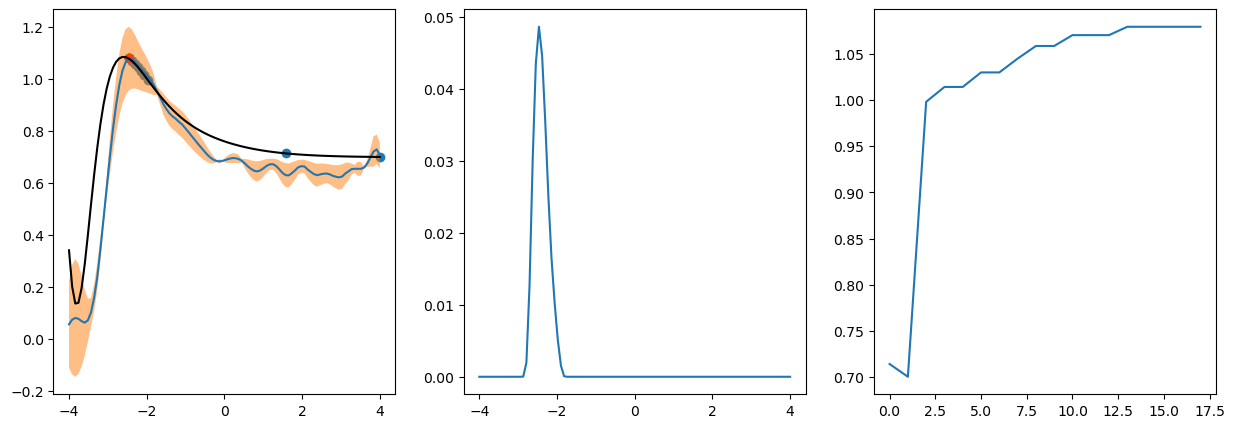

In [33]:
i = 0 
while x_best != true_x_best and i < n_iter:
    # Get the GP predictions for the test grid
    mu_s, cov_s = gp(X_test)
    sigma_s = torch.sqrt(torch.diag(cov_s).abs())

    # Calculate the Expected Improvement
    ei = expected_improvement(mu_s[:,0], sigma_s, y_best, xi = xi, minimise = minimise)

    # Find the next best point
    next_index = torch.argmax(ei)
    next_x = X_test[next_index]
    next_y = Y_test[next_index]

    # Update the training data with the new point
    X_train = torch.cat((X_train, next_x.unsqueeze(0)), dim=0)
    y_train = torch.cat((y_train, next_y.unsqueeze(0)), dim=0)

    # Update GP model with new data
    gp.X_train = X_train
    gp.y_train = y_train

    # Perform hyperparameter optimization if required
    if update_hyperparameters and (i + 1) % update_interval == 0:
        gp.optimize_hyperparameters(num_steps=hyperparam_steps, lr=lr, print_ = print_)

    # Update the best observed value
    if minimise:
        y_best = torch.min(y_train)
        x_best = X_train[torch.argmin(y_train)]
    else:
        y_best = torch.max(y_train)
        x_best = X_train[torch.argmax(y_train)]
        
    if print_:
        print(f"Iteration {i+1}: X = {x_best}, Y = {y_best}")

    i += 1

fig,axs = plt.subplots(1,3,figsize = (15,5))
axs[0].scatter(X_train,y_train)
axs[0].scatter(next_x,next_y, color = "red")
axs[0].plot(X_test,mu_s.detach())
axs[0].plot(X_test,Y_test, color = "black")
axs[0].fill_between(X_test[:,0],(mu_s[:,0] - sigma_s).detach(),(mu_s[:,0] + sigma_s).detach(), alpha = 0.5)
axs[1].plot(X_test,ei)
axs[2].plot(y_train)

In [13]:
X = Normal(0,1).sample((100,1))
y = X + Normal(0,1).sample((100,1))

def ypred(y,X,x):
    return x @ X.T @ torch.linalg.solve(X @ X.T+1e-4*torch.eye(100),y)

x = X

def pseudo_inv(x,X):
    return torch.linalg.solve(X @ X.T+1e-3*torch.eye(100),X @ x.T)

yhat = ypred(y,X,x)
matpred = pseudo_inv(X,X)

print(matpred)

tensor([[4.0337e-03, 9.8811e-03, 6.1645e-04,  ..., 5.4145e-03, 9.0552e-03,
         7.8012e-03],
        [9.9159e-03, 2.4529e-02, 1.5154e-03,  ..., 1.3310e-02, 2.2260e-02,
         1.8939e-02],
        [6.1587e-04, 1.5087e-03, 9.4119e-05,  ..., 8.1927e-04, 1.3826e-03,
         1.1911e-03],
        ...,
        [5.3002e-03, 1.3087e-02, 8.1099e-04,  ..., 7.1943e-03, 1.2151e-02,
         1.0365e-02],
        [8.9690e-03, 2.2121e-02, 1.3536e-03,  ..., 1.2057e-02, 2.0164e-02,
         1.7372e-02],
        [7.8480e-03, 1.8957e-02, 1.1855e-03,  ..., 1.0277e-02, 1.7386e-02,
         1.4978e-02]])


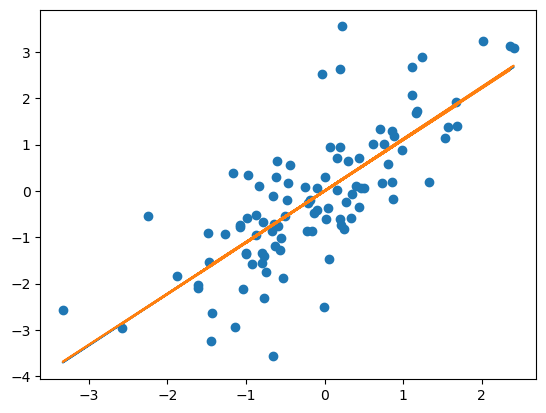

In [14]:
plt.plot(X, matpred.T @ y)
plt.plot(X,yhat)
plt.scatter(X,y)